In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from numpy import array
from datetime import datetime
import seaborn as sns

2022-10-18 01:24:50.867589: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-18 01:24:50.867623: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
sns.set_style("darkgrid")
cm = 1/2.54 
colors = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

### Replace missing values with Zero and Group by month

In [3]:
df1 = pd.read_csv('../records_hour_30inst_1.csv', parse_dates=['interval_start'])
df1.drop(df1.columns[0], axis=1, inplace=True)
df1.rename(columns = {'interval_start':'date'}, inplace = True)
df1 = df1.groupby('date').sum()
df1 = df1.resample(rule='H').sum()
df1 = df1[1624:]

In [4]:
df2 = pd.read_csv('../records_hour_30inst_2.csv', parse_dates=['interval_start'])
df2.drop(df2.columns[0], axis=1, inplace=True)
df2.rename(columns = {'interval_start':'date'}, inplace = True)
df2 = df2.groupby('date').sum()
df2 = df2.resample(rule='H').sum()
df2 = df2[1624:]

In [5]:
df3 = pd.read_csv('../records_hour_30inst_3.csv', parse_dates=['interval_start'])
df3.drop(df3.columns[0], axis=1, inplace=True)
df3.rename(columns = {'interval_start':'date'}, inplace = True)
df3 = df3.groupby('date').sum()
df3 = df3.resample(rule='H').sum()
df3 = df3[1624:]

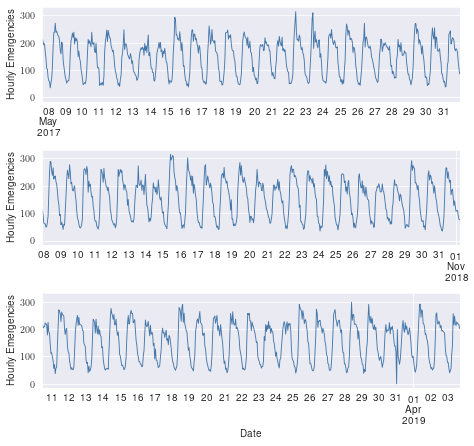

In [76]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(17*cm, 8*2*cm), sharey=True)
axes[0].set(ylabel='Hourly Emergencies')
axes[1].set(ylabel='Hourly Emergencies')
axes[2].set(ylabel='Hourly Emergencies')
df1.plot(linewidth=0.9, alpha=1, color=colors[0], legend=None, ax=axes[0], xlabel='')
df2.plot(linewidth=0.9, alpha=1, color=colors[0], legend=None, ax=axes[1], xlabel='')
df3.plot(linewidth=0.9, alpha=1, color=colors[0], legend=None, ax=axes[2], xlabel='Date')

plt.tight_layout()
plt.savefig('figures/emergencies_hourly.pdf', bbox_inches = "tight")

### Create batches of training data (12 months)

In [7]:
def split_sequence(sequence, n_steps_in, n_steps_out, slide):
    X, y = list(), list()
    for i in range(0, len(sequence), slide):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

### Define and fit LSTM model 

In [8]:
def fit(X, y, n_steps_in, n_steps_out):
    callback = EarlyStopping(monitor='loss', patience=50)
    model = Sequential()
    model.add(LSTM(units=50, activation='relu', input_shape=(n_steps_in, 1)))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mae')
    model.fit(X, y, epochs=500, callbacks=[callback])
    return model 

In [9]:
def train_predict(dataset, test, actual):
    n_steps_in, n_steps_out, slide = 24, 6, 1
    X, y = split_sequence(dataset, n_steps_in, n_steps_out, slide)
    
    model = fit(X, y, n_steps_in, n_steps_out)
    
    mae, rmse, smape = list(), list(), list()
    for i in range(0, len(test)-n_steps_in, n_steps_out):
        x_input = array(test[i:n_steps_in+i])
        x_input = x_input.reshape((1, n_steps_in, 1))
        pred = model.predict(x_input).reshape(-1, 1)
        pred = scaler.inverse_transform(pred)
        mae_aux, rmse_aux, smape_aux = measure_error(actual, pred, n_steps_in, n_steps_out, i)
        mae.append(mae_aux), rmse.append(rmse_aux), smape.append(smape_aux)
    
    return mae, rmse, smape

In [10]:
def sMAPE(actual, predicted):
    if not all([isinstance(actual, np.ndarray), 
                isinstance(predicted, np.ndarray)]):
        actual, predicted = np.array(actual),
        np.array(predicted)
    return round(np.mean(np.abs(predicted - actual) / ((np.abs(predicted) + np.abs(actual))/2))*100, 2)

In [11]:
def measure_error(actual, pred, step_in, step_out, index):
    #print(actual[index+step_in:index+step_in+step_out],pred,index+step_in,index+step_in+step_out)
    mae = mean_absolute_error(actual[index+step_in:index+step_in+step_out], pred)
    rmse = np.sqrt(mean_squared_error(actual[index+step_in:index+step_in+step_out], pred))
    smape = sMAPE(actual[index+step_in:index+step_in+step_out], pred)
    return mae, rmse, smape

### Normalize Data Set and Split Train and Test

In [12]:
len(df1)

584

In [13]:
dataset = df1.values
dataset = df1.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train=dataset[:500] 
test=dataset[500:]  
mae1, rmse1, smape1 = train_predict(train, test, df1[500:].values)

2022-10-18 01:24:57.655770: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-18 01:24:57.655813: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist
2022-10-18 01:24:57.656196: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/500
15/15 [==============================] - 2s 11ms/step - loss: 0.3922
Epoch 2/500
15/15 [==============================] - 0s 14ms/step - loss: 0.2993
Epoch 3/500
15/15 [==============================] - 0s 13ms/step - loss: 0.2227
Epoch 4/500
15/15 [==============================] - 0s 14ms/step - loss: 0.2000
Epoch 5/500
15/15 [==============================] - 0s 15ms/step - loss: 0.1727
Epoch 6/500
15/15 [==============================] - 0s 16ms/step - loss: 0.1459
Epoch 7/500
15/15 [==============================] - 0s 15ms/step - loss: 0.1317
Epoch 8/500
15/15 [==============================] - 0s 14ms/step - loss: 0.1228
Epoch 9/500
15/15 [==============================] - 0s 11ms/step - loss: 0.1279
Epoch 10/500
15/15 [==============================] - 0s 12ms/step - loss: 0.1379
Epoch 11/500
15/15 [==============================] - 0s 10ms/step - loss: 0.1238
Epoch 12/500
15/15 [==============================] - 0s 11ms/step - loss: 0.1145
Epoch 13/500
15/15 [=====

15/15 [==============================] - 0s 12ms/step - loss: 0.0570
Epoch 102/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0576
Epoch 103/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0598
Epoch 104/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0577
Epoch 105/500
15/15 [==============================] - 0s 11ms/step - loss: 0.0559
Epoch 106/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0569
Epoch 107/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0563
Epoch 108/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0555
Epoch 109/500
15/15 [==============================] - 0s 11ms/step - loss: 0.0557
Epoch 110/500
15/15 [==============================] - 0s 11ms/step - loss: 0.0553
Epoch 111/500
15/15 [==============================] - 0s 11ms/step - loss: 0.0547
Epoch 112/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0560
Epoch 113/500
15/1

15/15 [==============================] - 0s 12ms/step - loss: 0.0527
Epoch 200/500
15/15 [==============================] - 0s 11ms/step - loss: 0.0527
Epoch 201/500
15/15 [==============================] - 0s 11ms/step - loss: 0.0527
Epoch 202/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0527
Epoch 203/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0546
Epoch 204/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0536
Epoch 205/500
15/15 [==============================] - 0s 11ms/step - loss: 0.0531
Epoch 206/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0523
Epoch 207/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0530
Epoch 208/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0531
Epoch 209/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0534
Epoch 210/500
15/15 [==============================] - 0s 11ms/step - loss: 0.0536
Epoch 211/500
15/1

15/15 [==============================] - 0s 15ms/step - loss: 0.0502
Epoch 298/500
15/15 [==============================] - 0s 21ms/step - loss: 0.0514
Epoch 299/500
15/15 [==============================] - 0s 15ms/step - loss: 0.0503
Epoch 300/500
15/15 [==============================] - 0s 13ms/step - loss: 0.0506
Epoch 301/500
15/15 [==============================] - 0s 13ms/step - loss: 0.0508
Epoch 302/500
15/15 [==============================] - 0s 14ms/step - loss: 0.0501
Epoch 303/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0491
Epoch 304/500
15/15 [==============================] - 0s 14ms/step - loss: 0.0496
Epoch 305/500
15/15 [==============================] - 0s 17ms/step - loss: 0.0499
Epoch 306/500
15/15 [==============================] - 0s 18ms/step - loss: 0.0501
Epoch 307/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0500
Epoch 308/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0503
Epoch 309/500
15/1

15/15 [==============================] - 0s 11ms/step - loss: 0.0486
Epoch 396/500
15/15 [==============================] - 0s 11ms/step - loss: 0.0493
Epoch 397/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0489
Epoch 398/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0486
Epoch 399/500
15/15 [==============================] - 0s 11ms/step - loss: 0.0487
Epoch 400/500
15/15 [==============================] - 0s 11ms/step - loss: 0.0486
Epoch 401/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0490
Epoch 402/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0487
Epoch 403/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0479
Epoch 404/500
15/15 [==============================] - 0s 11ms/step - loss: 0.0480
Epoch 405/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0488
Epoch 406/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0491
Epoch 407/500
15/1

15/15 [==============================] - 0s 22ms/step - loss: 0.0473
Epoch 494/500
15/15 [==============================] - 0s 21ms/step - loss: 0.0476
Epoch 495/500
15/15 [==============================] - 0s 14ms/step - loss: 0.0473
Epoch 496/500
15/15 [==============================] - 0s 14ms/step - loss: 0.0476
Epoch 497/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0478
Epoch 498/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0467
Epoch 499/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0466
Epoch 500/500
15/15 [==============================] - 0s 15ms/step - loss: 0.0472


In [14]:
dataset = df2.values
dataset = df2.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train=dataset[:500] 
test=dataset[500:]  
mae2, rmse2, smape2 = train_predict(train, test, df2[500:].values)

Epoch 1/500
15/15 [==============================] - 1s 11ms/step - loss: 0.4136
Epoch 2/500
15/15 [==============================] - 0s 12ms/step - loss: 0.2993
Epoch 3/500
15/15 [==============================] - 0s 12ms/step - loss: 0.2444
Epoch 4/500
15/15 [==============================] - 0s 12ms/step - loss: 0.2109
Epoch 5/500
15/15 [==============================] - 0s 12ms/step - loss: 0.1974
Epoch 6/500
15/15 [==============================] - 0s 12ms/step - loss: 0.1681
Epoch 7/500
15/15 [==============================] - 0s 12ms/step - loss: 0.1440
Epoch 8/500
15/15 [==============================] - 0s 12ms/step - loss: 0.1357
Epoch 9/500
15/15 [==============================] - 0s 16ms/step - loss: 0.1374
Epoch 10/500
15/15 [==============================] - 0s 13ms/step - loss: 0.1259
Epoch 11/500
15/15 [==============================] - 0s 12ms/step - loss: 0.1229
Epoch 12/500
15/15 [==============================] - 0s 12ms/step - loss: 0.1210
Epoch 13/500
15/15 [=====

15/15 [==============================] - 0s 23ms/step - loss: 0.0580
Epoch 102/500
15/15 [==============================] - 0s 20ms/step - loss: 0.0583
Epoch 103/500
15/15 [==============================] - 0s 22ms/step - loss: 0.0603
Epoch 104/500
15/15 [==============================] - 0s 21ms/step - loss: 0.0602
Epoch 105/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0581
Epoch 106/500
15/15 [==============================] - 0s 23ms/step - loss: 0.0583
Epoch 107/500
15/15 [==============================] - 0s 20ms/step - loss: 0.0585
Epoch 108/500
15/15 [==============================] - 0s 14ms/step - loss: 0.0588
Epoch 109/500
15/15 [==============================] - 0s 15ms/step - loss: 0.0581
Epoch 110/500
15/15 [==============================] - 0s 14ms/step - loss: 0.0570
Epoch 111/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0570
Epoch 112/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0572
Epoch 113/500
15/1

15/15 [==============================] - 0s 12ms/step - loss: 0.0533
Epoch 200/500
15/15 [==============================] - 0s 11ms/step - loss: 0.0530
Epoch 201/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0555
Epoch 202/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0538
Epoch 203/500
15/15 [==============================] - 0s 11ms/step - loss: 0.0526
Epoch 204/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0540
Epoch 205/500
15/15 [==============================] - 0s 11ms/step - loss: 0.0533
Epoch 206/500
15/15 [==============================] - 0s 11ms/step - loss: 0.0536
Epoch 207/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0529
Epoch 208/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0527
Epoch 209/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0541
Epoch 210/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0534
Epoch 211/500
15/1

15/15 [==============================] - 0s 12ms/step - loss: 0.0516
Epoch 298/500
15/15 [==============================] - 0s 11ms/step - loss: 0.0513
Epoch 299/500
15/15 [==============================] - 0s 11ms/step - loss: 0.0514
Epoch 300/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0518
Epoch 301/500
15/15 [==============================] - 0s 11ms/step - loss: 0.0511
Epoch 302/500
15/15 [==============================] - 0s 11ms/step - loss: 0.0513
Epoch 303/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0515
Epoch 304/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0506
Epoch 305/500
15/15 [==============================] - 0s 11ms/step - loss: 0.0506
Epoch 306/500
15/15 [==============================] - 0s 11ms/step - loss: 0.0533
Epoch 307/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0518
Epoch 308/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0525
Epoch 309/500
15/1

15/15 [==============================] - 0s 12ms/step - loss: 0.0496
Epoch 396/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0498
Epoch 397/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0493
Epoch 398/500
15/15 [==============================] - 0s 13ms/step - loss: 0.0490
Epoch 399/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0496
Epoch 400/500
15/15 [==============================] - 0s 17ms/step - loss: 0.0499
Epoch 401/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0488
Epoch 402/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0495
Epoch 403/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0495
Epoch 404/500
15/15 [==============================] - 0s 13ms/step - loss: 0.0486
Epoch 405/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0490
Epoch 406/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0491
Epoch 407/500
15/1

15/15 [==============================] - 0s 12ms/step - loss: 0.0489
Epoch 494/500
15/15 [==============================] - 0s 13ms/step - loss: 0.0488
Epoch 495/500
15/15 [==============================] - 0s 14ms/step - loss: 0.0489
Epoch 496/500
15/15 [==============================] - 0s 13ms/step - loss: 0.0490
Epoch 497/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0478
Epoch 498/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0477
Epoch 499/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0498
Epoch 500/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0477


In [15]:
dataset = df3.values
dataset = df3.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train=dataset[:500] 
test=dataset[500:]  
mae3, rmse3, smape3 = train_predict(train, test, df3[500:].values)

Epoch 1/500
15/15 [==============================] - 2s 13ms/step - loss: 0.4395
Epoch 2/500
15/15 [==============================] - 0s 13ms/step - loss: 0.2898
Epoch 3/500
15/15 [==============================] - 0s 16ms/step - loss: 0.2256
Epoch 4/500
15/15 [==============================] - 0s 20ms/step - loss: 0.1882
Epoch 5/500
15/15 [==============================] - 0s 14ms/step - loss: 0.1530
Epoch 6/500
15/15 [==============================] - 0s 16ms/step - loss: 0.1275
Epoch 7/500
15/15 [==============================] - 0s 13ms/step - loss: 0.1224
Epoch 8/500
15/15 [==============================] - 0s 13ms/step - loss: 0.1118
Epoch 9/500
15/15 [==============================] - 0s 13ms/step - loss: 0.1122
Epoch 10/500
15/15 [==============================] - 0s 12ms/step - loss: 0.1173
Epoch 11/500
15/15 [==============================] - 0s 13ms/step - loss: 0.1096
Epoch 12/500
15/15 [==============================] - 0s 13ms/step - loss: 0.1072
Epoch 13/500
15/15 [=====

15/15 [==============================] - 0s 12ms/step - loss: 0.0542
Epoch 102/500
15/15 [==============================] - 0s 14ms/step - loss: 0.0579
Epoch 103/500
15/15 [==============================] - 0s 15ms/step - loss: 0.0580
Epoch 104/500
15/15 [==============================] - 0s 15ms/step - loss: 0.0553
Epoch 105/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0549
Epoch 106/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0543
Epoch 107/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0541
Epoch 108/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0541
Epoch 109/500
15/15 [==============================] - 0s 13ms/step - loss: 0.0540
Epoch 110/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0558
Epoch 111/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0538
Epoch 112/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0531
Epoch 113/500
15/1

15/15 [==============================] - 0s 12ms/step - loss: 0.0498
Epoch 200/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0496
Epoch 201/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0526
Epoch 202/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0522
Epoch 203/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0502
Epoch 204/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0510
Epoch 205/500
15/15 [==============================] - 0s 11ms/step - loss: 0.0494
Epoch 206/500
15/15 [==============================] - 0s 11ms/step - loss: 0.0510
Epoch 207/500
15/15 [==============================] - 0s 14ms/step - loss: 0.0494
Epoch 208/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0490
Epoch 209/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0487
Epoch 210/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0488
Epoch 211/500
15/1

15/15 [==============================] - 0s 14ms/step - loss: 0.0473
Epoch 298/500
15/15 [==============================] - 0s 20ms/step - loss: 0.0478
Epoch 299/500
15/15 [==============================] - 0s 15ms/step - loss: 0.0467
Epoch 300/500
15/15 [==============================] - 0s 13ms/step - loss: 0.0470
Epoch 301/500
15/15 [==============================] - 0s 17ms/step - loss: 0.0482
Epoch 302/500
15/15 [==============================] - 0s 15ms/step - loss: 0.0469
Epoch 303/500
15/15 [==============================] - 0s 14ms/step - loss: 0.0476
Epoch 304/500
15/15 [==============================] - 0s 15ms/step - loss: 0.0476
Epoch 305/500
15/15 [==============================] - 0s 13ms/step - loss: 0.0477
Epoch 306/500
15/15 [==============================] - 0s 15ms/step - loss: 0.0476
Epoch 307/500
15/15 [==============================] - 0s 13ms/step - loss: 0.0475
Epoch 308/500
15/15 [==============================] - 0s 14ms/step - loss: 0.0475
Epoch 309/500
15/1

15/15 [==============================] - 0s 11ms/step - loss: 0.0468
Epoch 396/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0460
Epoch 397/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0462
Epoch 398/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0466
Epoch 399/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0456
Epoch 400/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0464
Epoch 401/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0465
Epoch 402/500
15/15 [==============================] - 0s 13ms/step - loss: 0.0468
Epoch 403/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0459
Epoch 404/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0462
Epoch 405/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0464
Epoch 406/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0459
Epoch 407/500
15/1

15/15 [==============================] - 0s 12ms/step - loss: 0.0464
Epoch 494/500
15/15 [==============================] - 0s 13ms/step - loss: 0.0452
Epoch 495/500
15/15 [==============================] - 0s 14ms/step - loss: 0.0448
Epoch 496/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0447
Epoch 497/500
15/15 [==============================] - 0s 13ms/step - loss: 0.0446
Epoch 498/500
15/15 [==============================] - 0s 12ms/step - loss: 0.0465
Epoch 499/500
15/15 [==============================] - 0s 18ms/step - loss: 0.0463
Epoch 500/500
15/15 [==============================] - 0s 23ms/step - loss: 0.0451


In [16]:
mae = mae1 + mae2 + mae3
rmse = rmse1 + rmse2 + rmse3
smape = smape1 + smape2 + smape3

### Calculate Error

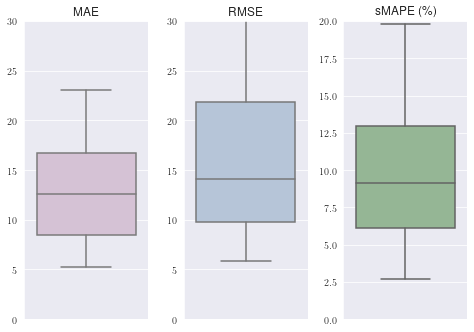

In [17]:
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(17*cm,12*cm))
sns.boxplot(ax=axes[0], y=mae, color='thistle', showfliers=False)
axes[0].set_title('MAE')
axes[0].set(ylim=(0, 30))
sns.boxplot(ax=axes[1], y=rmse, color='lightsteelblue', showfliers=False)
axes[1].set_title('RMSE')
axes[1].set(ylim=(0, 30))
sns.boxplot(ax=axes[2], y=smape, color='darkseagreen', showfliers=False)
axes[2].set_title('sMAPE (\%)')
axes[2].set(ylim=(0, 20))
plt.tight_layout()
#plt.savefig('figures/emergencies_lstm_hourly_boxplot.pdf')

In [19]:
emer_lstm_hour = [mae,rmse,smape]
%store emer_lstm_hour

Stored 'emer_lstm_hour' (list)
